In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anti-uav-yolo-1024/valid/labels/01028.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01484.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00588.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00286.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00080.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01279.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00440.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02557.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01936.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00733.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00134.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01466.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00709.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00372.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01850.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02017.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02363.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01

In [28]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

In [29]:
from sklearn import preprocessing


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

import glob
import cv2
from PIL import Image

In [30]:
BASE_PATH = "/kaggle/input/anti-uav-yolo-1024/train"
TXT_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/labels/*.txt")
IMG_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/images/*.jpg")
IMG_PATH2 = glob.glob("/kaggle/input/anti-uav-yolo-1024/valid/images/*.jpg")

In [31]:
def convert_format(box, iwidth=1024, iheight=1024):
    x_center, y_center, width, height = box
    
    x_min = int((x_center - width / 2) * iwidth)
    y_min = int((y_center - height / 2) * iheight)
    x_max = int((x_center + width / 2) * iwidth)
    y_max = int((y_center + height / 2) * iheight)
    
    return [x_min, y_min, x_max, y_max]

In [32]:
import os
from PIL import Image

train_image = []
train_image_path = []
train_image_id = []
train_annotation = []

for img_path in IMG_PATH:
    # Extract image ID
    image_id = os.path.basename(img_path).split('.')[0]
   

    # Construct path for annotation file
    annotation_path = os.path.join("/kaggle/input/anti-uav-yolo-1024/train/labels/", image_id + ".txt")

    # Check if annotation file exists
    if os.path.exists(annotation_path):
        # Check if annotation file is not empty
        if os.path.getsize(annotation_path) > 0:
            Load_image = Image.open(img_path).convert('RGB')
            nmpy_img = Load_image.resize((258, 258))
            train_image.append(np.asarray(nmpy_img))
            train_image_path.append(img_path)
            train_image_id.append(image_id)

            # Read annotation file
            with open(annotation_path) as f:
                lines = f.readlines()
                tmp_lst = lines[0].split(' ')
                startX = float(tmp_lst[1])
                startY = float(tmp_lst[2])
                endX = float(tmp_lst[3])
                endY = float(tmp_lst[4])

                train_annotation.append(convert_format([startX, startY, endX, endY]))
        else:
            print(f"Annotation file is empty for image: {img_path}")
    else:
        print(f"Annotation file not found for image: {img_path}")

print("Images and annotations processed successfully.")


Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00639.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00724.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00579.jpg
Images and annotations processed successfully.


In [33]:
for img_path in IMG_PATH2:
    # Extract image ID
    image_id = os.path.basename(img_path).split('.')[0]
    

    # Construct path for annotation file
    annotation_path = os.path.join("/kaggle/input/anti-uav-yolo-1024/valid/labels/", image_id + ".txt")

    # Check if annotation file exists
    if os.path.exists(annotation_path):
        # Check if annotation file is not empty
        if os.path.getsize(annotation_path) > 0:
            Load_image = Image.open(img_path).convert('RGB')
            nmpy_img = Load_image.resize((258, 258))
            train_image.append(np.asarray(nmpy_img))
            train_image_path.append(img_path)
            train_image_id.append(image_id)

            # Read annotation file
            with open(annotation_path) as f:
                lines = f.readlines()
                tmp_lst = lines[0].split(' ')
                startX = float(tmp_lst[1])
                startY = float(tmp_lst[2])
                endX = float(tmp_lst[3])
                endY = float(tmp_lst[4])

                train_annotation.append(convert_format([startX, startY, endX, endY]))
        else:
            print(f"Annotation file is empty for image: {img_path}")
    else:
        print(f"Annotation file not found for image: {img_path}")

print("Images and annotations processed successfully.")

Images and annotations processed successfully.


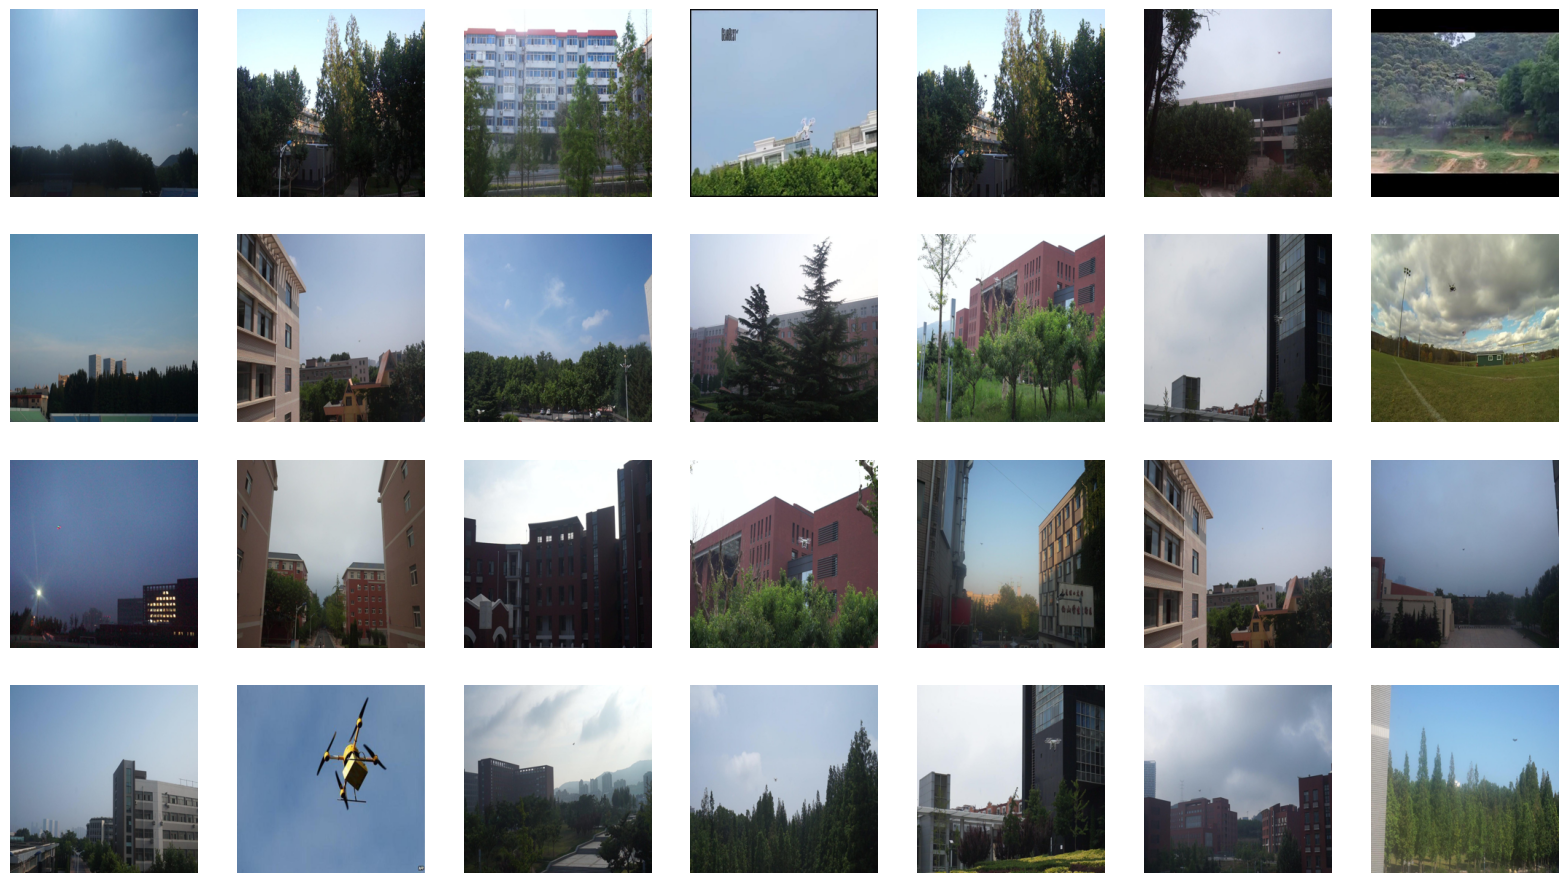

In [34]:
plt.figure(figsize=(20, 20))

for i in range(28):
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(train_image[i].astype("uint8"))
    plt.axis("off")

In [35]:
df = pd.DataFrame()
df['boxes'] = train_annotation
df['img_path'] = train_image_path
df['labels'] = 'drone'
df['img_id'] = train_image_id

In [36]:
df

boxes                                           img_path  \
0     [566, 703, 580, 714]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
1     [296, 360, 318, 383]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
2     [469, 381, 481, 390]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
3     [576, 594, 682, 716]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
4     [361, 352, 388, 381]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
...                    ...                                                ...   
7792  [457, 261, 536, 310]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   
7793  [435, 126, 450, 146]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   
7794  [522, 583, 539, 599]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   
7795  [267, 375, 346, 433]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   
7796  [609, 428, 655, 490]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   

     labels img_id  
0     drone  04168  
1     drone  02371  
2     drone  04377  
3     drone  00767  
4     drone  02360  
...     ...    ...  
7792  drone  00319  
7793  drone  01863  
7794  drone  01325  
7795  drone  00222  
7796  drone  00117  

[7797 rows x 4 columns]

In [37]:
import numpy as np
from sklearn import preprocessing

enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['labels'])
df['labels'] = np.stack([df['labels'][i]+1 for i in range(len(df['labels']))])

In [38]:
import numpy as np

# Assuming df['boxes'] contains arrays/lists of coordinates
# Create separate columns for 'xmin', 'ymin', 'xmax', 'ymax'
df[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df['boxes'].apply(lambda x: np.array(x)).values)

# Drop the 'boxes' column
df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(float)
df['ymin'] = df['ymin'].astype(float)
df['xmax'] = df['xmax'].astype(float)
df['ymax'] = df['ymax'].astype(float)

In [54]:
df_removed_damaged1 = df.drop(df[(df.ymin >= df.ymax) | (df.xmin >= df.xmax)].index)
df_removed_damaged1

mask = (df['ymin'] > 1024) | (df['ymax'] > 1024) | (df['xmin'] > 1024) | (df['xmax'] > 1024)
# Drop rows where the condition is True
df_removed_damaged = df_removed_damaged1.drop(df[mask].index)

In [55]:
train_ds=df_removed_damaged[:6000]
val_ds=df_removed_damaged[6000:]
val_ds

img_path  labels img_id   xmin  \
6005  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  01263  392.0   
6006  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  01024  269.0   
6007  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  01726  613.0   
6008  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  01803  188.0   
6009  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  01598  512.0   
...                                                 ...     ...    ...    ...   
7792  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  00319  457.0   
7793  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  01863  435.0   
7794  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  01325  522.0   
7795  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  00222  267.0   
7796  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  00117  609.0   

       ymin   xmax   ymax  
6005  380.0  406.0  401.0  
6006  547.0  283.0  562.0  
6007    0.0  628.0   16.0  
6008  459.0  208.0  479.0  
6009  549.0  528.0  570.0  
...     ...    ...    ...  
7792  261.0  536.0  310.0  
7793  126.0  450.0  146.0  
7794  583.0  539.0  599.0  
7795  375.0  346.0  433.0  
7796  428.0  655.0  490.0  

[1791 rows x 7 columns]

In [56]:
class TrainDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.resize(image, (1024, 1024))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        if len(boxes) == 0:
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64),
                'image_id': torch.tensor([index]),
                'area': torch.zeros(0, dtype=torch.float32),
                'iscrowd': torch.zeros(0, dtype=torch.int64)
            }
        else:

            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            label = records['labels'].values
            labels = torch.as_tensor(label, dtype=torch.int64)

            # Suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([index]),
                'area': area,
                'iscrowd': iscrowd
            }

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

            # Only stack the boxes if there are non-empty bounding boxes
            if len(sample['bboxes']) > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [57]:
def get_transform_train():
    return A.Compose([
        #A.Flip(0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),

        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [58]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = TrainDataset(train_ds, '/kaggle/input/anti-uav-yolo-1024/train/images', get_transform_train())
valid_dataset = TrainDataset(val_ds, '/kaggle/input/anti-uav-yolo-1024/train/images', get_transform_train())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [60]:
images,targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]

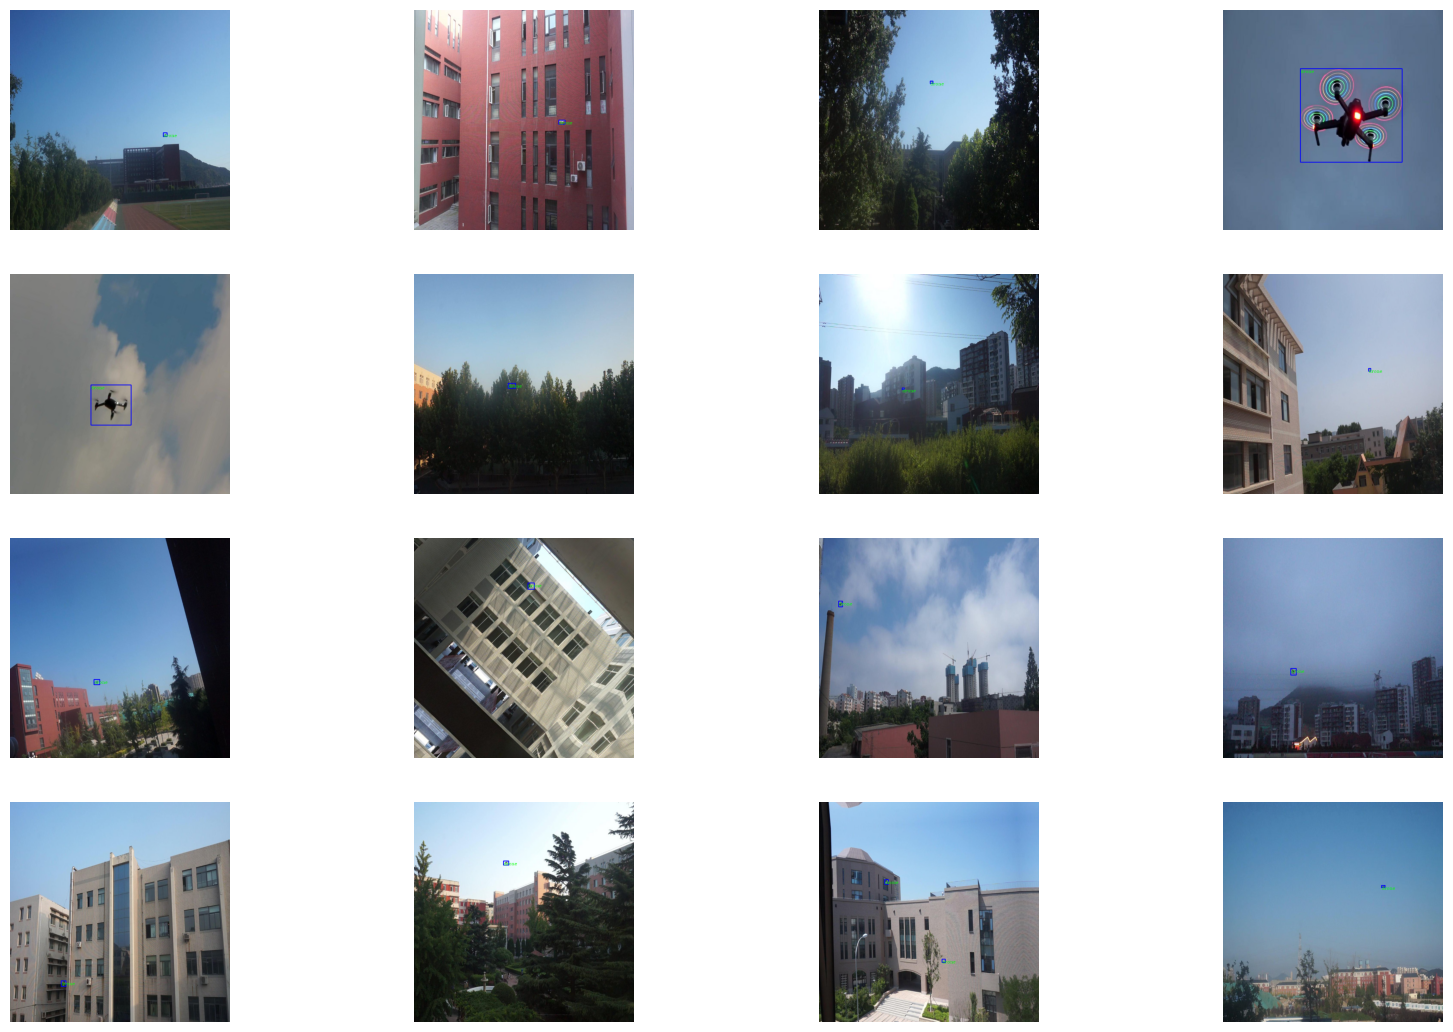

In [61]:
classes= {1:'drone'}

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(6,4, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy() * 255
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)

In [62]:
for i, (image, target) in enumerate(zip(images, targets)):
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    for i,box in enumerate(boxes):
        print(box[0], box[1],box[2], box[3])

557 446 571 460
526 400 549 415
404 258 414 267
281 213 651 553
294 403 440 549
342 397 369 415
302 414 310 420
529 343 537 353
305 514 326 533
414 163 437 186
71 229 85 250
246 474 266 498
186 650 203 670
325 214 344 229
239 282 252 299
447 571 459 583
576 303 589 311


In [63]:
!pip install pycocotools
! pip install -U ffmpeg

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torch.optim as optim
import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import torchvision.transforms.functional as tf
import albumentations as A
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

In [65]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
num_classes=2

in_channels=det_utils.retrieve_out_channels(model.backbone,(1024,1024))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [66]:
for params in model.backbone.features.parameters():
    params.requires_grad=False
    
parameters=[params for params in model.parameters() if params.requires_grad]

learning_rate=3e-5
optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=7, threshold=0.0001)

In [67]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [68]:
"""Model has been trained and its weights are stored in pothole-detection-learned-weights,
if you want to train it yourself uncomment the below code, it takes around 50 minutes."""

epochs=30
loss_history={"training_loss":[],
              "validation_loss":[]}

train_len=len(train_data_loader.dataset)
val_len=len(valid_data_loader.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    
    training_loss=0.0
    validation_loss=0.0
    
    current_lr=get_lr(optimizer)
    
    #During training, the model expects both the input tensors, as well as a targets 
    model.train()
    for imgs,targets in train_data_loader:
        imgs=[img.to(device) for img in imgs]
        #targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        #targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
        
        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    with torch.no_grad():
        for imgs,targets in valid_data_loader:
            imgs=[img.to(device) for img in imgs]
            #targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
            #targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
            targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
            
            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()
        
            
    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)
    
    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")
        
    
    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)
            
    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)

#torch.save(best_weights,model_weights_file)

Updating Best Model weights

1/30
Training Loss: 0.6468285511975181
Validation_loss: 1.2689861490529846

**************************************************
Updating Best Model weights

2/30
Training Loss: 0.5674455058947762
Validation_loss: 1.1677322166324766

**************************************************
Updating Best Model weights

3/30
Training Loss: 0.5282581856432127
Validation_loss: 1.0898252454397983

**************************************************
Updating Best Model weights

4/30
Training Loss: 0.4982534172720618
Validation_loss: 1.0301839701684916

**************************************************
Updating Best Model weights

5/30
Training Loss: 0.47608066888732475
Validation_loss: 0.9871714128894394

**************************************************
Updating Best Model weights

6/30
Training Loss: 0.45256694835303396
Validation_loss: 0.9592070029331615

**************************************************
Updating Best Model weights

7/30
Training Loss: 0.43826554658

In [69]:
loss_history

{'training_loss': [0.6468285511975181,
  0.5674455058947762,
  0.5282581856432127,
  0.4982534172720618,
  0.47608066888732475,
  0.45256694835303396,
  0.43826554658616534,
  0.4218836989662054,
  0.4118593250519581,
  0.404728791649087,
  0.39768789949996075,
  0.3958800480362182,
  0.3970770698205541,
  0.3896487666080751,
  0.38616934026645633,
  0.39040254810415764,
  0.38639761208541856,
  0.38552372701080473,
  0.3811197146881964,
  0.38434102470375175,
  0.3780660009970672,
  0.38070442551521355,
  0.3811592001533766,
  0.3778998772347222,
  0.38332606126239366,
  0.3787707201080473,
  0.3815462461712604,
  0.37931538741470283,
  0.38194393689085177,
  0.3756237423474521],
 'validation_loss': [1.2689861490529846,
  1.1677322166324766,
  1.0898252454397983,
  1.0301839701684916,
  0.9871714128894394,
  0.9592070029331615,
  0.9307707688242782,
  0.9140855442611789,
  0.8987839456405403,
  0.8862066614933629,
  0.8918198924822827,
  0.8761014486940847,
  0.8750404213851848,
  0.8

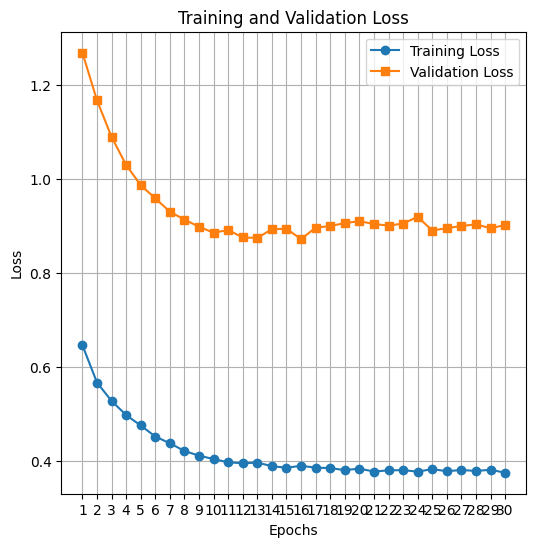

In [70]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(6, 6))
plt.plot(range(1, epochs+1),loss_history["training_loss"], label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), loss_history["validation_loss"], label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xticks(range(1, epochs+1))
plt.legend()
plt.grid(True)
plt.show()

In [71]:
from torchmetrics.detection import MeanAveragePrecision
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

MeanAveragePrecision()

In [ ]:
MeanAveragePrecision()
threshold=0.25
iou_threshold=0.75
iou=10
def preprocess_bbox(prediction):
    
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

In [ ]:
model.eval()
with torch.no_grad():
    for imgs,targets in valid_data_loader:
        imgs=[img.to(device) for img in imgs]
        #targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
        predictions=model(imgs)
        
        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))
        
        metric.update(results,targets)
 

In [ ]:
results=metric.compute()
ssd_mean_ap=results["map"].item()
ssd_mean_ap_50=results["map_50"].item()
ssd_mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {ssd_mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {ssd_mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {ssd_mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.0006
Mean Average Precision @ 0.5          : 0.0021
Mean Average Precision @ 0.75         : 0.0000


In [ ]:
import json

# Save loss_history dictionary to a JSON file
with open('loss_history.json', 'w') as json_file:
    json.dump(loss_history, json_file)

In [ ]:
torch.save(model.state_dict(), 'ssdmodeldict.pth')

In [ ]:
torch.save(model, 'ssdentire_model.pth')